In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from matplotlib.ticker import MultipleLocator
warnings.filterwarnings("ignore", category=RuntimeWarning)

Opsi 1 CF = Emisi total/ GFRAC physical area

In [28]:
df_all_sources = pd.read_excel("all_sources_concat_5years_rice_13 Jan_v4_25_minus&Tahunan.xlsx", sheet_name='Sheet1')
df_GFRACcombined = pd.read_excel("GFRACcombined_area_concat.xlsx")
country_code = pd.read_excel("D:/kerja/asisten riset/vol/milkunC/achaidir/LUH2 2022/ISO-3166-Country-Code_Final.xlsx")

In [126]:
def ngfbfc_processing(df):
    try:
        if "type" in df.columns.to_list():
            df = df.rename(columns={"type": "NGFBFC"})

        if 'NGFBFC' in df.columns:
            df['NGFBFC'] = df['NGFBFC'].str.lower()
            df['NGFBFC'] = df['NGFBFC'].replace("oil & palm fruit", "palm oil")
            df['NGFBFC'] = df['NGFBFC'].replace("other non-food & luxury & spices", "non food, luxury, spices")
            df['NGFBFC'] = df['NGFBFC'].replace('other temperate cereals', 'temperate cereals')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def region_processing(df):
    try:
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df
    
def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0

In [70]:
start_year = 1975
end_year = 2021
columns = ['IMAGE Region Name', 'NGFBFC'] + [x for x in range(start_year, end_year, 5)]

df_all_sources_copy = df_all_sources.copy()
df_all_sources_copy = df_all_sources_copy.drop(columns=['Unnamed: 0'])
df_all_sources_copy = ngfbfc_processing(df_all_sources_copy)
df_all_sources_selected = df_all_sources_copy[~df_all_sources_copy['NGFBFC'].str.contains("pasture")]

df_all_sources_selected = df_all_sources_selected[columns]
df_all_sources_selected = df_all_sources_selected.groupby(['IMAGE Region Name', 'NGFBFC']).sum().reset_index()

df_all_sources_melt = df_all_sources_selected.melt(id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
df_all_sources_melt['value'] = df_all_sources_melt['value'] * 1e9
df_all_sources_melt

,IMAGE Region Name,NGFBFC,time,value
0,Brazil,maize,1975,8.596400e+07
1,Brazil,"non food, luxury, spices",1975,2.241761e+07
2,Brazil,palm oil,1975,5.117042e+04
3,Brazil,plant based fibres,1975,4.237654e+07
4,Brazil,pulses,1975,3.550717e+07
...,...,...,...,...
4155,W. Europe,tropical cereals,2020,1.086560e+05
4156,W. Europe,tropical oil crops,2020,1.358663e+03
4157,W. Europe,tropical roots & tubers,2020,6.225164e+02
4158,W. Europe,vegetables & fruits,2020,1.719034e+06


In [94]:
df_GFRACcombined_copy = df_GFRACcombined.copy()
df_GFRACcombined_copy = ngfbfc_processing(df_GFRACcombined_copy)
df_GFRACcombined_selected = df_GFRACcombined_copy[~df_GFRACcombined_copy['NGFBFC'].str.contains("grass")]

df_GFRACcombined_selected = pd.merge(left=country_code, right=df_GFRACcombined_selected, how="left", left_on="ISO Country", right_on="country")
df_GFRACcombined_selected = df_GFRACcombined_selected[columns]
df_GFRACcombined_selected = df_GFRACcombined_selected[~(df_GFRACcombined_selected['IMAGE Region Name'] == "N|A")]
df_GFRACcombined_selected = df_GFRACcombined_selected.groupby(['IMAGE Region Name', 'NGFBFC']).sum().reset_index()

df_GFRACcombined_melt = pd.melt(df_GFRACcombined_selected, id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
df_GFRACcombined_melt

,IMAGE Region Name,NGFBFC,time,value
0,Brazil,maize,1975,1.181281e+07
1,Brazil,"non food, luxury, spices",1975,3.007450e+06
2,Brazil,palm oil,1975,4.623242e+03
3,Brazil,plant based fibres,1975,4.754033e+06
4,Brazil,pulses,1975,4.444202e+06
...,...,...,...,...
4155,W. Europe,tropical cereals,2020,1.870749e+05
4156,W. Europe,tropical oil crops,2020,3.265995e+03
4157,W. Europe,tropical roots & tubers,2020,4.155261e+03
4158,W. Europe,vegetables & fruits,2020,9.568875e+06


In [103]:
CF_emisi_total_GFRAC_area = df_all_sources_melt.copy()
CF_emisi_total_GFRAC_area = CF_emisi_total_GFRAC_area.drop(columns=['value'])
IMAGERegionName	= CF_emisi_total_GFRAC_area["IMAGE Region Name"].to_list()
time = CF_emisi_total_GFRAC_area["time"].to_list()
ngfbfc = CF_emisi_total_GFRAC_area["NGFBFC"].to_list()

for region, time, ngfbfc in zip(IMAGERegionName, time, ngfbfc):
    try:
        data1 = df_all_sources_melt[(df_all_sources_melt['IMAGE Region Name'] == region) & (df_all_sources_melt['time'] == time) & (df_all_sources_melt['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        data2 = df_GFRACcombined_melt[(df_GFRACcombined_melt['IMAGE Region Name'] == region) & (df_GFRACcombined_melt['time'] == time) & (df_GFRACcombined_melt['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = df_all_sources_melt[(df_all_sources_melt['IMAGE Region Name'] == region) & (df_all_sources_melt['time'] == time) & (df_all_sources_melt['NGFBFC'] == ngfbfc)].index
        CF_emisi_total_GFRAC_area.loc[mask, 'CF'] = data1[0] / data2[0]
    except KeyError as e:
        print(f"Error: {e} for region {region}")

CF_emisi_total_GFRAC_area['CF'] = CF_emisi_total_GFRAC_area['CF'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
# CF_emisi_total_GFRAC_replace.to_excel("X:/cadlan/stream_2/Step5/CF_Emisitotal_GFRACarea_AM1_14Jan_minus.xlsx",  index=False)

Opsi 2: CF = Emisi/ GFRAC Area Harvested 

In [117]:
df_GFRAC_Area = pd.read_csv("D:/kerja/asisten riset/code v/review/GFRAC_Area_Harvested_combined.csv")
df_GFRAC_Area.head()

,IMAGE Region Name,NGFBFC,time,value
0,Brazil,Maize,1970,1.129294e+07
1,Brazil,Maize,1975,1.208552e+07
2,Brazil,Maize,1980,1.078206e+07
3,Brazil,Maize,1985,1.065404e+07
4,Brazil,Maize,1990,1.301961e+07


In [116]:
df_GFRAC_Area_copy = df_GFRAC_Area.copy()
df_GFRAC_Area_copy = df_GFRAC_Area_copy[df_GFRAC_Area_copy['time'] >= start_year]
df_GFRAC_Area_copy = ngfbfc_processing(df_GFRAC_Area_copy)
df_GFRAC_Area_selected = df_GFRAC_Area_copy[~df_GFRAC_Area_copy['NGFBFC'].str.contains("grass")]
df_GFRAC_Area_selected

,IMAGE Region Name,NGFBFC,time,value
1,Brazil,maize,1975,1.208552e+07
2,Brazil,maize,1980,1.078206e+07
3,Brazil,maize,1985,1.065404e+07
4,Brazil,maize,1990,1.301961e+07
5,Brazil,maize,1995,1.577528e+07
...,...,...,...,...
4571,W. Europe,wheat,2000,1.779400e+07
4572,W. Europe,wheat,2005,1.769292e+07
4573,W. Europe,wheat,2010,1.770521e+07
4574,W. Europe,wheat,2015,1.750669e+07


In [118]:
CF_emisi_total_AH = df_all_sources_melt.copy()
CF_emisi_total_AH = CF_emisi_total_AH.drop(columns=['value'])
IMAGERegionName = CF_emisi_total_AH["IMAGE Region Name"].to_list()
time = CF_emisi_total_AH["time"].to_list()
ngfbfc = CF_emisi_total_AH["NGFBFC"].to_list()

for region, time, ngfbfc in zip(IMAGERegionName, time, ngfbfc):
    try:
        data1 = df_all_sources_melt[(df_all_sources_melt['IMAGE Region Name'] == region) & (df_all_sources_melt['time'] == time) & (df_all_sources_melt['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        data2 = df_GFRAC_Area_selected[(df_GFRAC_Area_selected['IMAGE Region Name'] == region) & (df_GFRAC_Area_selected['time'] == time) & (df_GFRAC_Area_selected['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = df_all_sources_melt[(df_all_sources_melt['IMAGE Region Name'] == region) & (df_all_sources_melt['time'] == time) & (df_all_sources_melt['NGFBFC'] == ngfbfc)].index
        CF_emisi_total_AH.loc[mask, 'CF'] = data1[0] / data2[0]
    except KeyError as e:
        print(f"Error: {e} for region {region}")

CF_emisi_total_AH['CF'] = CF_emisi_total_AH['CF'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [120]:
CF_emisi_total_AH_average = CF_emisi_total_AH.groupby(['IMAGE Region Name', 'NGFBFC']).mean().reset_index()
# CF_emisi_total_AH.to_excel("X:/cadlan/stream_2/Step5/CF_emisitotal_AH_14Jan_years_minus.xlsx",  index=False)
# CF_emisi_total_AH_average.to_excel("X:/cadlan/stream_2/Step5/CF_emisitotal_AH_14Jan_average_minns.xlsx", index=False)

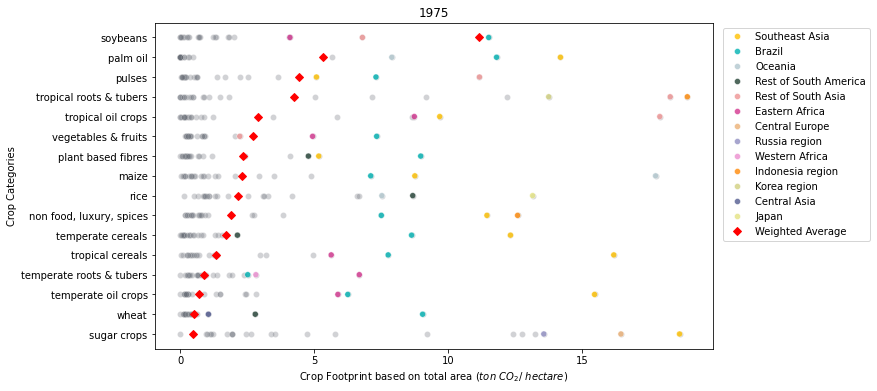

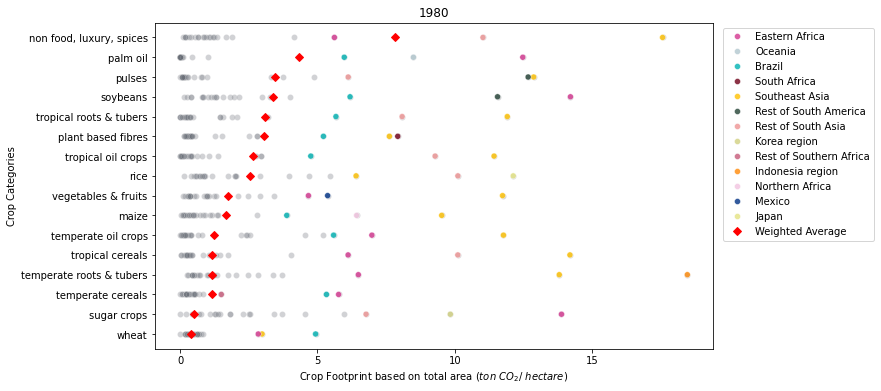

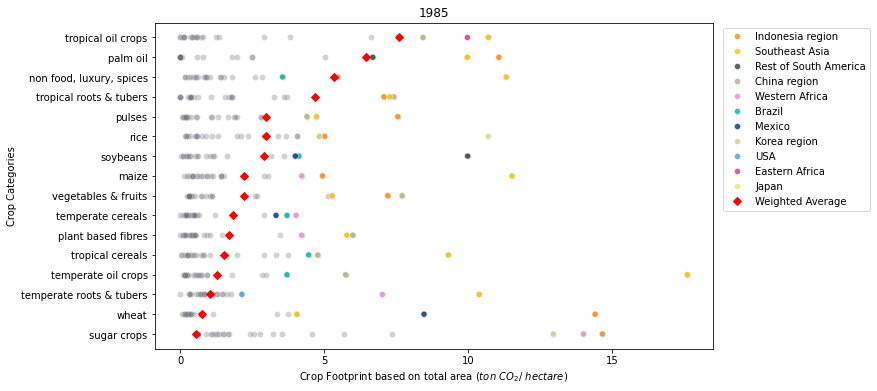

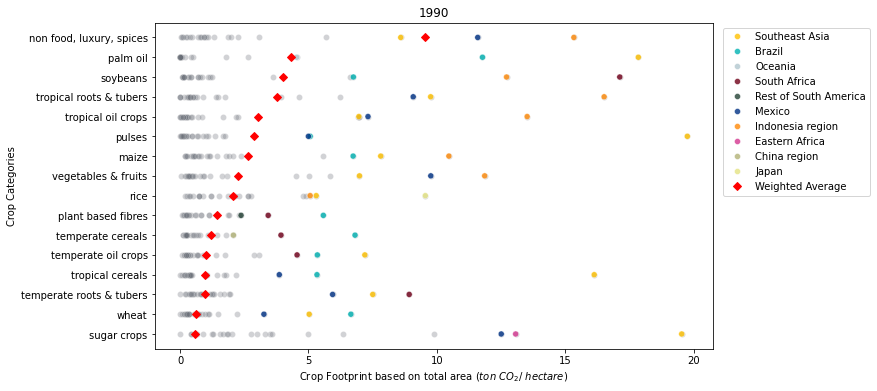

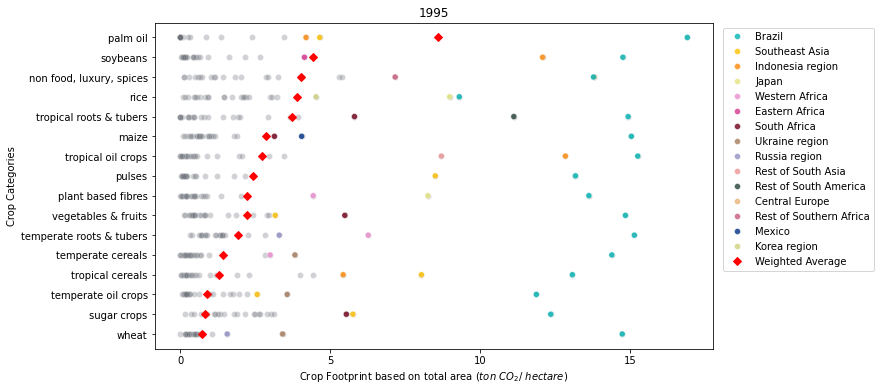

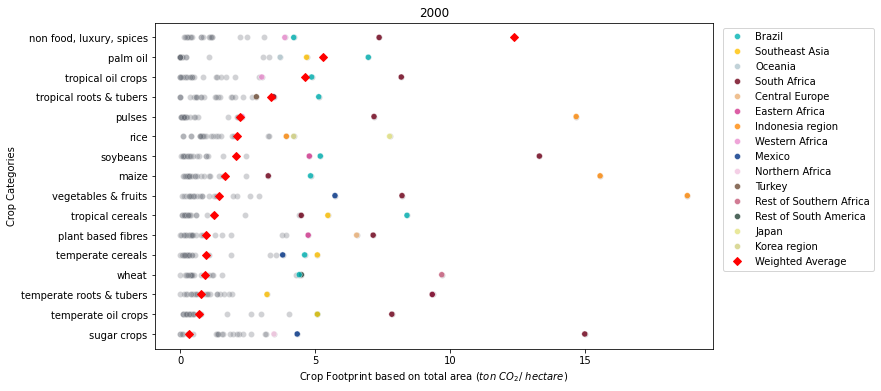

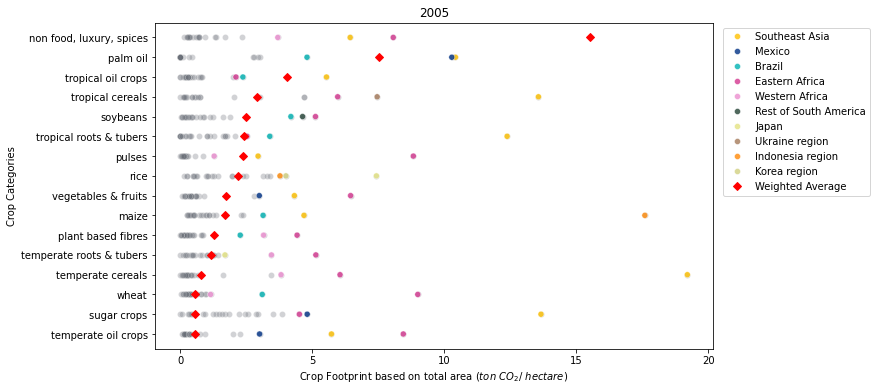

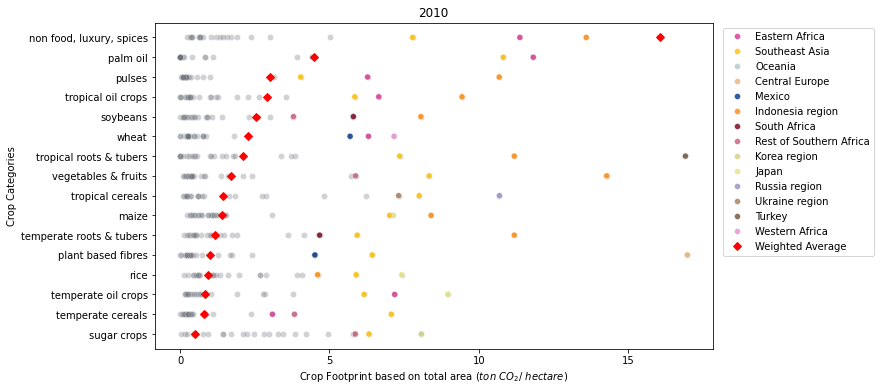

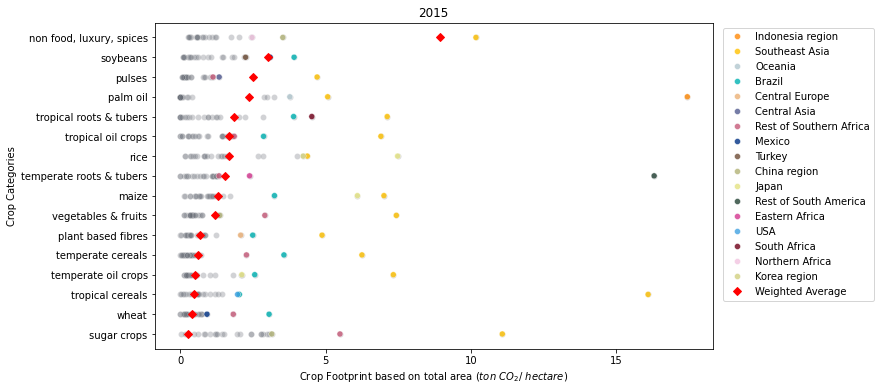

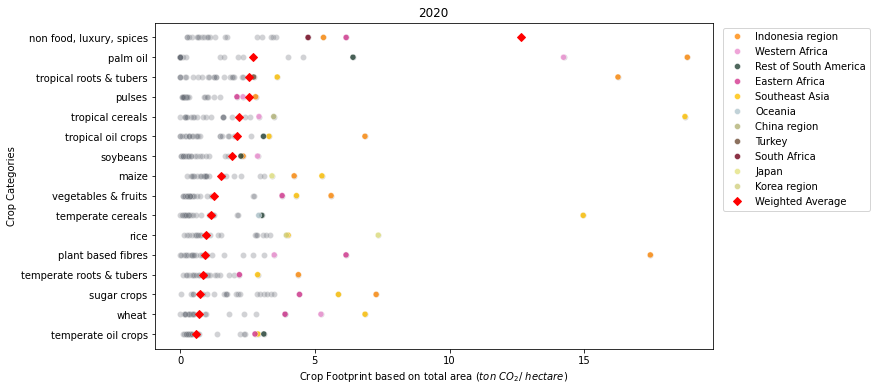

In [127]:
df1 = CF_emisi_total_AH.copy()
df2 = df_GFRAC_Area_selected.copy()

df1.loc[df1['CF'] > 50, 'CF'] = 0
df1 = ngfbfc_processing(df1)
df2 = ngfbfc_processing(df2)

data1 = np.zeros((10, 16, 26), dtype='float32')
average_AreaHarvested_RegionCrops = np.zeros((10, 16, 26), dtype='float32')
result_average = np.zeros((16, 10), dtype='float32')

for n, time in enumerate(range(start_year, end_year, 5)):
    for i, ngfbfc in enumerate(df1['NGFBFC'].unique()):
        for j, image_region in enumerate(df2['IMAGE Region Name'].unique()):
            ngfbfc_areaharves = df2[(df2['time'] == time) & (df2['IMAGE Region Name'] == image_region) & (df2['NGFBFC'] == ngfbfc)]['value'].replace([np.inf, -np.inf], np.nan).values
            average_AreaHarvested_RegionCrops[n][i][j] = np.nan_to_num(ngfbfc_areaharves)

for n, time in enumerate(range(start_year, end_year, 5)):
    for i, ngfbfc in enumerate(df1['NGFBFC'].unique()):
        carbon_footprint = df1[(df1['time'] == time) & (df1['NGFBFC'] == ngfbfc)]['CF'].replace([np.inf, -np.inf], np.nan).values
        data1[n][i] = np.nan_to_num(carbon_footprint)

for i, ngfbfc in enumerate(df1['NGFBFC'].unique()):    
    for n, time in enumerate(range(start_year, end_year, 5)):
        result_average[i][n] = np.average(data1[n][i], weights=average_AreaHarvested_RegionCrops[n][i])

df_avg = pd.DataFrame(result_average, index=[df2['NGFBFC'].unique()], columns=list(range(start_year, end_year, 5)))
df_avg = df_avg.reset_index()
df_avg = df_avg.rename(columns={"level_0" : 'NGFBFC'})
df_avg_melt = pd.melt(
    df_avg, 
    id_vars=["NGFBFC"],  # Kolom yang tetap
    var_name="time",     # Nama kolom untuk nilai tahun
    value_name="value"   # Nama kolom untuk nilai data
)
df_avg = df_avg_melt.sort_values(by=['value', 'NGFBFC'], ascending=[False, False])

results = {}

for category in df_avg['NGFBFC'].unique():
    for time in range(start_year, end_year, 5):
        filtered_data = df_avg[(df_avg['NGFBFC'] == category) & (df_avg['time'] == time)]
        sorted_data = filtered_data.sort_values(by='value', ascending=False)
        top_5_data = sorted_data.head(3)
        if time not in results:
            results[time] = {}
        results[time][category] = top_5_data

df_avg = pd.concat([pd.concat(results[year].values()) for year in results.keys()])
df_avg = df_avg.sort_values(by=['time', 'value'], ascending=[True, False])
df_avg = ngfbfc_processing(df_avg)

produk_diulang = np.array([item for item in df_avg[df_avg['time'] == 1980]['NGFBFC'].to_list() for _ in range(1)])

df_footprint_region = region_processing(df1)
df_footprint_region_table = pd.pivot_table(data=df_footprint_region, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
df_footprint_region_index = df_footprint_region_table.stack(level=0, future_stack=True)
df_footprint_region_index = df_footprint_region_index.reset_index()
df_footprint_region_index_drop = df_footprint_region_index.drop(columns=['level_2'])
df_footprint_region_index_drop.index = df_footprint_region_index_drop['NGFBFC'].values

average1_melt = df_footprint_region_index_drop.melt(id_vars=['NGFBFC', 'time'], value_name='value') 
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Canada"))]
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Central America"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "tropical cereals") & (average1_melt['IMAGE Region Name'] == "Japan"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "South Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "Rest of Southern Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "USA"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "non food, luxury, spices") & (average1_melt['IMAGE Region Name'] == "Russia region"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "soybeans") & (average1_melt['IMAGE Region Name'] == "Southeast Asia"))]

average1_melt.index = average1_melt['NGFBFC'].values
average1_filtered = average1_melt[average1_melt['value'] < 20]

results = {}
average1_new = average1_filtered.sort_values(by=['value', 'NGFBFC'], ascending=[True, True])

for country in average1_new['IMAGE Region Name'].unique():
    for category in average1_new['NGFBFC'].unique():
        for time in range(1975, 2021, 5):
            filtered_data = average1_new[(average1_new['NGFBFC'] == category) & (average1_new['time'] == time)]
            sorted_data = filtered_data.sort_values(by='value', ascending=False)
            top_5_data = sorted_data.head(3)
            if time not in results:
                results[time] = {}
            results[time][category] = top_5_data

df_footprint_df = pd.concat([pd.concat(results[year].values()) for year in results.keys()])
df_footprint_df_filtered = df_footprint_df[df_footprint_df['value'] < 20]


palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#C75B7A','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

for time in range(1975, 2021, 5):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Crop Footprint based on total area ($ton~CO_2/~hectare$)')
    ax.set_ylabel('Crop Categories')

    plt.title(f"{time}")
    
    produk_diulang = np.array([item for item in df_avg[df_avg['time'] == time]['NGFBFC'].to_list() for _ in range(1)])

    sns.scatterplot(x="value", y="NGFBFC", color='#686D76',
                    sizes=(100, 300), alpha=.3, data=average1_filtered[average1_filtered['time'] == time].loc[produk_diulang])

    sns.scatterplot(x="value", y="NGFBFC", hue='IMAGE Region Name',
                    sizes=(100, 300), alpha=.8, palette=palettes, data=df_footprint_df_filtered[df_footprint_df_filtered['time'] == time])

    ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    ax.plot(df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['value'].to_numpy(), df_avg[df_avg['time'] == time].sort_values(by='value', ascending=False)['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    weighted_average_index = legend_labels.index('Weighted Average')
    weighted_average_handle = legend_handles.pop(weighted_average_index)
    weighted_average_label = legend_labels.pop(weighted_average_index)
    legend_handles.append(weighted_average_handle)
    legend_labels.append(weighted_average_label)

    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
    ax.xaxis.set_major_locator(MultipleLocator(5))

    plt.show()

C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_2656/2499943162.py:42: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_footprint_region_index = df_footprint_region_table.stack(level=0)


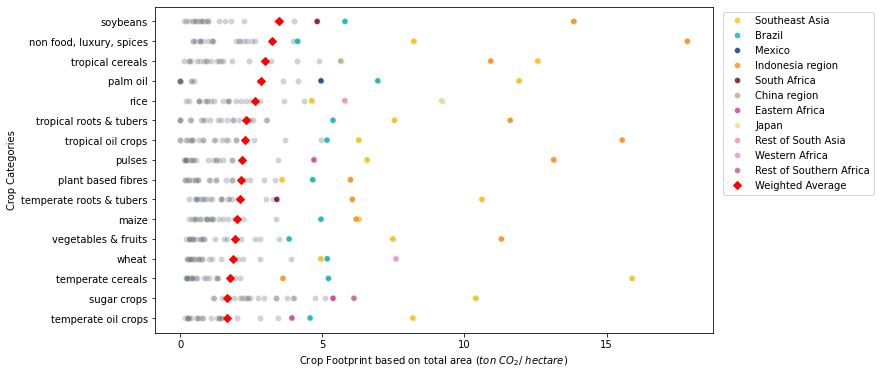

In [128]:

df1 = CF_emisi_total_AH.copy()
df2 = df_GFRAC_Area_selected.copy()

df1.loc[df1['CF'] > 50, 'CF'] = 0
df1 = ngfbfc_processing(df1)
df2 = ngfbfc_processing(df2)

data1 = np.zeros((16, 26), dtype='float32')
average_AreaHarvested_RegionCrops = np.zeros((16, 26), dtype='float32')
result_average = np.zeros((16), dtype='float32')

for i, ngfbfc in enumerate(df1['NGFBFC'].unique()):
    for n, image_region in enumerate(df2['IMAGE Region Name'].unique()):
        ngfbfc_areaharves = df2[(df2['IMAGE Region Name'] == image_region) & (df2['NGFBFC'] == ngfbfc) & (df2['value'] > 0)]['value'].replace([np.inf, -np.inf], np.nan).mean()
        average_AreaHarvested_RegionCrops[i][n] = np.nan_to_num(ngfbfc_areaharves)

for i, ngfbfc in enumerate(df1['NGFBFC'].unique()):
    carbon_footprint = df1[df1['NGFBFC'] == ngfbfc]['CF'].replace([np.inf, -np.inf], np.nan).mean()
    data1[i] = np.nan_to_num(carbon_footprint)

for x in range(0, 16):
    result_average[x] = np.average(data1[x], weights=average_AreaHarvested_RegionCrops[x])

df_avg = pd.DataFrame(result_average, index=df2['NGFBFC'].unique(), columns=['value'])
df_avg = df_avg.reset_index()
df_avg = df_avg.rename(columns={"index":'NGFBFC'})
df_avg = df_avg.sort_values(by=['value'], ascending=[False])

df_avg['NGFBFC'] = df_avg['NGFBFC'].replace('grass', 'pasture').replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
produk_diulang = np.array([item for item in df_avg['NGFBFC'].to_list() for _ in range(1)])

df_footprint_region = region_processing(df1)
df_footprint_region_table = pd.pivot_table(data=df_footprint_region, index=['NGFBFC', 'time'], columns=['IMAGE Region Name'])
df_footprint_region_index = df_footprint_region_table.stack(level=0, future_stack=True)
df_footprint_region_index = df_footprint_region_index.reset_index()
df_footprint_region_index_drop = df_footprint_region_index.drop(columns=['level_2'])
df_footprint_region_index_drop = df_footprint_region_index_drop.drop(columns=['time'])
df_footprint_region_index_drop.index = df_footprint_region_index_drop['NGFBFC'].values

average1_melt = df_footprint_region_index_drop.melt(id_vars=['NGFBFC'], value_name='value') 
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Canada"))]
average1_melt = average1_melt[~((average1_melt['IMAGE Region Name'] == "Central America"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "tropical cereals") & (average1_melt['IMAGE Region Name'] == "Japan"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "South Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "Rest of Southern Africa"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "palm oil") & (average1_melt['IMAGE Region Name'] == "USA"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "non food, luxury, spices") & (average1_melt['IMAGE Region Name'] == "Russia region"))]
average1_melt = average1_melt[~((average1_melt['NGFBFC'] == "soybeans") & (average1_melt['IMAGE Region Name'] == "Southeast Asia"))]

average = average1_melt.groupby(['IMAGE Region Name', 'NGFBFC'])['value'].mean().to_frame('Mean')
average1 = average.reset_index()

average1.index = average1['NGFBFC'].values
average1_filtered = average1[average1['Mean'] < 20]

results = {}
average1_new = average1_filtered.sort_values(by=['Mean', 'NGFBFC'], ascending=[True, True])

for country in average1_new['IMAGE Region Name'].unique():
    for category in average1_new['NGFBFC'].unique():
        filtered_data = average1_new[average1_new['NGFBFC'] == category]
        sorted_data = filtered_data.sort_values(by='Mean', ascending=False)
        top_5_data = sorted_data.head(3)
        results[category] = top_5_data

df_footprint_df = pd.concat([pd.concat(results.values())])
df_footprint_df_filtered = df_footprint_df[df_footprint_df['Mean'] < 20]


fig, ax = plt.subplots(figsize=(10, 6))

palettes = {'Oceania': '#B3C8CF','Japan':'#E5E483','Korea region':'#D2D180','China region':'#B2B377','Rest of South Asia':'#EF9595',
                'India':'#EFB495','Indonesia region':'#FF8A08','Southeast Asia':'#FFC100','Middle East':'#1B1A55','Central Asia':'#535C91',
                'Russia region':'#9290C3','Rest of Southern Africa':'#C75B7A','South Africa':'#710019','Eastern Africa':'#D43790',
                'Western Africa':'#EC8FD0','Northern Africa':'#F2C5E0', 'Turkey':'#6F4E37','Ukraine region':'#A67B5B','Central Europe':'#ECB176',
                'Western Europe':'#FED8B1', 'Rest of South America':'#254336','Brazil':'#00b2b2','Central America':'#B3E2A7','Mexico':'#003285',
                'USA':'#40A2E3','Canada':'#BBE2EC'}

ax.set_xlabel('Crop Footprint based on total area ($ton~CO_2/~hectare$)')
ax.set_ylabel('Crop Categories')
sns.scatterplot(x="Mean", y="NGFBFC", color='#686D76',
                sizes=(100, 300), alpha=.3, data=average1_filtered.loc[produk_diulang])

sns.scatterplot(x="Mean", y="NGFBFC", hue='IMAGE Region Name',
                sizes=(100, 300), alpha=.8, palette=palettes, data=df_footprint_df_filtered)

ax.legend(bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
ax.plot(df_avg['value'].to_numpy(), df_avg['NGFBFC'].to_numpy(), "D", color='red', label='Weighted Average')
legend_handles, legend_labels = ax.get_legend_handles_labels()
weighted_average_index = legend_labels.index('Weighted Average')
weighted_average_handle = legend_handles.pop(weighted_average_index)
weighted_average_label = legend_labels.pop(weighted_average_index)
legend_handles.append(weighted_average_handle)
legend_labels.append(weighted_average_label)

ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), ncol=1, loc='upper left')
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(5))

plt.show()